#### This code was developed as part of AI_for_High_Energy_Physics.
#### For more details, visit: https://github.com/karlschwarz/AI_for_HEP

In [1]:
import numpy as np
from numba import njit
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [3]:
#@njit
def likelihood(state, O_star=100, sigma_star=10):
    """
    Compute the Gaussian-like function L(x1, x2) = exp(-(O(x1, x2) - O_star)^2 / (2 * sigma_star^2)).

    Parameters:
    x1 (float): The first input variable.
    x2 (float): The second input variable.
    O_star (float): The target value for the potential.
    sigma_star (float): The width parameter of the Gaussian.
    O (function): The potential function O(x1, x2).

    Returns:
    float: The value of L(x1, x2).
    """
    # Compute the potential O(x1, x2)
    x1, x2 = state[0], state[1]
    potential = eggbox(x1, x2)
    
    # Compute the Gaussian-like function
    exponent = -((potential - O_star) ** 2) / (2 * sigma_star ** 2)
    return math.exp(exponent)

In [4]:
def loglikelihood(samples, O_star=100, sigma_star=10):
    """
    Compute the log-likelihood of samples under a Gaussian distribution.

    Parameters:
    - samples: numpy array of shape [num_samples, 2]
        The input samples for which to compute the log-likelihood.
    - O_star: float
        The mean of the Gaussian distribution (same for both dimensions).
    - sigma_star: float
        The standard deviation of the Gaussian distribution.

    Returns:
    - log_likelihood: float
        The log-likelihood of the samples.
    """
    # Mean and covariance
    mean = np.array([O_star, O_star])
    cov = np.eye(2) * sigma_star
    
    # Compute the Mahalanobis distance term
    diff = samples - mean  # Shape: [num_samples, 2]
    inv_cov = np.linalg.inv(cov)  # Shape: [2, 2]
    term = np.dot(diff, np.dot(inv_cov, diff.T))  # Shape: [num_samples, num_samples]
    
    # Take the trace to sum the diagonal elements (contributions from each sample)
    trace_term = np.trace(term)  # Scalar
    
    # Compute the log-likelihood
    log_likelihood = -0.5 * trace_term / samples.shape[0]
    
    return log_likelihood

In [5]:
#@njit
def eggbox(x1, x2):
    """
    Calculate the potential O1(x1, x2) = (2 + cos(x1/2) * cos(x2/2))^5.

    Parameters:
    x1 (float or np.ndarray): The first input variable (scalar or array).
    x2 (float or np.ndarray): The second input variable (scalar or array).

    Returns:
    float or np.ndarray: The value of the potential O1(x1, x2).
    """
    if np.isscalar(x1) and np.isscalar(x2):
        # Scalar inputs
        return (2.0 + math.cos(x1 / 2.0) * math.cos(x2 / 2.0)) ** 5
    else:
        # Convert inputs to numpy arrays if they're not already
        x1 = np.asarray(x1)
        x2 = np.asarray(x2)
        # Element-wise computation for arrays
        obs = (2.0 + np.cos(x1 / 2.0) * np.cos(x2 / 2.0)) ** 5
        return obs

In [ ]:
def plot_heatmap(samples, likelihood_values, x1_range, x2_range, plot_file="./simu/samples_likelihood_dnn.pdf"):
    """
    Plot a heatmap of the samples, colored by their likelihood.

    Args:
        samples (numpy array): Array of samples with shape (num_samples, 2).
        likelihood_values (numpy array): Likelihood values for each sample.
        x1_range (tuple): Range for the x1 axis (min, max).
        x2_range (tuple): Range for the x2 axis (min, max).
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(samples[:, 0], samples[:, 1], c=likelihood_values, cmap='viridis', alpha=0.6, s=2)
    plt.colorbar(label='Likelihood')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(x1_range)
    plt.ylim(x2_range)
    # Find unique rows in the array
    unique_samples = np.unique(samples, axis=0)
    # Count the number of unique rows
    num_non_identical = samples.shape[0]
    plt.title(f'{num_non_identical} DNN Samples Colored by Likelihood')
    if plot_file:
        plt.savefig(plot_file, dpi=100)
        plt.show()
    else:
        plt.show()

In [7]:
class FeedforwardNN(nn.Module):
    """
    Feedforward Neural Network with ReLU activations and dropout layers.
    
    Args:
        input_size (int): Size of the input features.
        hidden_sizes (list): List of integers specifying the number of neurons in each hidden layer.
        output_size (int): Size of the output.
        dropout_prob (float): Dropout probability for dropout layers.
    """
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.0):
        super(FeedforwardNN, self).__init__()
        self.layers = nn.ModuleList()  # To store all layers
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        for layer in self.layers:
            x = F.relu(layer(x))  # Apply ReLU activation
            x = self.dropout(x)   # Apply dropout
        x = self.output_layer(x)  # Output layer (no activation)
        return x

In [8]:
def rejection_sampling(
    samples, dnn_outputs, likelihood_function, num_resamples, egg_function=eggbox, O_star=100, sigma_star=10, kde_bandwidth=None
):
    """
    Perform rejection sampling to resample DNN outputs based on a likelihood function.

    Args:
        dnn_samples (numpy array): Array of samples from the DNN.
        likelihood_function (function): A function that computes the likelihood of a sample.
        num_resamples (int): Number of samples to generate.
        kde_bandwidth (float, optional): Bandwidth for the KDE. If None, it is automatically determined.

    Returns:
        resampled_samples (numpy array): Resampled samples.
    """
    # Compute the likelihood (target density) of the DNN samples
    egg_potential = egg_function(samples[:, 0], samples[:, 1])
    target_log_density = -((egg_potential - O_star) ** 2) / (2 * sigma_star ** 2)

    # Compute the proposal density of the samples
    proposal_log_density = -((dnn_outputs - O_star) ** 2) / (2 * sigma_star ** 2)

    # Apply a threshold to avoid extremely small values
    #proposal_density = np.maximum(proposal_density, 1e-10)
    
    # Compute the ratio of target density to proposal density
    density_log_ratio = target_log_density - proposal_log_density
    density_ratio = np.exp(density_log_ratio)
    
    # Find the maximum ratio to normalize the acceptance probability
    log_M = np.max(density_log_ratio)

    # Ensure M is monotonically non-decreasing
    #M_max = max(M_max, M)
    
    # Compute the acceptance probability
    acceptance_prob = np.exp(density_log_ratio - log_M)
    acceptance_prob_avg = np.mean(acceptance_prob)
    
    # Perform rejection sampling
    resampled_idx = []
    while len(resampled_idx) < num_resamples:
        # Randomly select a sample from the DNN outputs
        idx = np.random.randint(0, len(samples))
        
        # Accept or reject the sample based on the acceptance probability
        if np.random.rand() < acceptance_prob[idx]:
            resampled_idx.append(idx)
    
    return np.array(resampled_idx, dtype=np.int16), acceptance_prob_avg

In [9]:
# Function to optimize the DNN using precomputed outputs and resampled pairs
def optimize_dnn_with_resampled_pairs(
    dnn, resampled_indices, dataset, device, num_epochs=1, batch_size=32, learning_rate=0.001
):
    """
    Optimize the DNN using precomputed outputs and resampled pairs.

    Args:
        dnn (nn.Module): The DNN model to optimize.
        resampled_indices (numpy array): Indices of the resampled samples.
        samples (numpy array): Original samples from the DNN.
        dnn_outputs (numpy array): Precomputed outputs from the DNN.
        eggbox_function (function): Function to compute the true labels.
        num_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
    """
    # Resample the data and DNN outputs
    samples, labels = dataset[0], dataset[1]
    resampled_samples = samples[resampled_indices]
    resampled_labels = labels[resampled_indices]
    
    # Convert to PyTorch tensors
    resampled_samples_tensor = torch.tensor(resampled_samples, dtype=torch.float32).to(device)
    resampled_labels_tensor = torch.tensor(resampled_labels, dtype=torch.float32).view(-1, 1).to(device)
    
    # Create a DataLoader
    dataset = TensorDataset(resampled_samples_tensor, resampled_labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
    
    # Training loop
    loss_sum = 0.0
    for epoch in range(num_epochs):
        for batch_samples, batch_labels in dataloader:
            # Forward pass
            outputs = dnn(batch_samples)
            
            # Compute loss
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.cpu().detach().numpy()
        
    loss_avg = loss_sum / num_epochs
    return resampled_samples, resampled_labels, loss_avg

In [10]:
def dataset_create(samples, egg_function=eggbox):
    labels = []
    for sample in samples:
        label = egg_function(sample[0], sample[1])
        labels.append(label)
    labels = np.array(labels).reshape(-1, 1)
    return samples, labels

In [11]:
def add_noise(samples, std=1.0):
    """
    Add Gaussian noise to a 2D array of samples.

    Parameters:
    - samples: numpy array of shape [num_samples, 2]
        The input samples to which noise will be added.
    - std: float
        The standard deviation of the Gaussian noise.

    Returns:
    - noisy_samples: numpy array of shape [num_samples, 2]
        The samples with added Gaussian noise.
    """
    # Generate Gaussian noise with mean 0 and standard deviation `std`
    noise = np.random.normal(0, std, size=samples.shape)
    
    # Add the noise to the original samples
    noisy_samples = samples + noise
    
    return noisy_samples

In [12]:
# Function to train the DNN iteratively with CUDA support
def train_dnn_iteratively(
    dnn, device, egg_function=eggbox, likelihood_function=likelihood,
    sample_range=(-15, 15), num_iterations=100, num_initial_samples=100,
    prop_new_samples=0.1, num_epochs=10, batch_size=32, learning_rate=0.001
):
    """
    Train the DNN iteratively using rejection sampling and uniform sampling with CUDA support.

    Args:
        dnn (nn.Module): The DNN model to train.
        egg_function (function): Function to compute the true labels.
        likelihood_function (function): Function to compute the likelihood of a sample.
        num_iterations (int): Number of training iterations.
        num_initial_samples (int): Number of initial uniformly sampled samples.
        num_new_samples (int): Number of new uniformly sampled samples in each iteration.
        num_epochs (int): Number of training epochs per iteration.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.
        device (torch.device): Device to use for computation (e.g., 'cuda' or 'cpu').
    """
    # Move the model to the specified device
    dnn.to(device)

    # Initialize the dataset with uniformly sampled points
    sample_collect = []
    loss_list = []
    accept_avg_list = []
    loglikelihood_list = []
    x1_range = sample_range
    x2_range = sample_range
    samples = np.random.uniform(low=x1_range[0], high=x1_range[1], size=(num_initial_samples, 2))  # 2D space
    dataset = dataset_create(samples, egg_function)
    visualization_interval = 100
    num_subsamples = int((1.0 - prop_new_samples) * len(samples))
    num_new_samples = num_initial_samples - num_subsamples

    folder_name = "./simu"
    if not os.path.exists(folder_name):
          # If the folder does not exist, create it
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:    
        print(f"Folder '{folder_name}' already exists.")

    for iteration in tqdm(range(num_iterations)):
        # Get the current outputs of the DNN (WITHOUT torch.no_grad())
        samples_tensor = torch.tensor(samples, dtype=torch.float32).to(device)  # Move samples to device
        dnn_outputs = dnn(samples_tensor).detach().cpu().numpy().flatten()  # Detach to avoid tracking gradients

        # Subsample the samples using rejection sampling
        resampled_indices, accept_avg = rejection_sampling(samples, dnn_outputs, likelihood, num_subsamples)
        accept_avg_list.append(accept_avg)

        # Train the DNN using the updated dataset
        resampled_samples, resampled_labels, loss_avg = optimize_dnn_with_resampled_pairs(
            dnn, resampled_indices, dataset, device, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate
        )
        loglikelihood_avg = loglikelihood(resampled_samples, O_star=100, sigma_star=10)
        loglikelihood_list.append(loglikelihood_avg)
        sample_collect.append(resampled_samples)
        loss_list.append(loss_avg)

        # Add 10 new uniformly sampled samples
        new_samples = np.random.uniform(low=x1_range[0], high=x1_range[1], size=(num_new_samples, 2))
        new_labels = dataset_create(new_samples, egg_function)[1]

        # Combine the resampled samples and new samples
        samples = np.vstack([resampled_samples, new_samples])
        labels = np.vstack([resampled_labels, new_labels])

        # Recreate the dataset again
        dataset = dataset_create(samples)

        # Visualize and save plots at the specified interval
        if (iteration + 1) % visualization_interval == 0:
            # Plot and save the loss
            plt.figure()
            plt.plot(range(1, iteration + 2), loss_list, label="Loss")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.title("Training Loss")
            plt.legend()
            plt.grid(True)
            plt.savefig("./simu/loss_plot.pdf", dpi=100)
            plt.close()

            # Plot and save the loss
            plt.figure()
            plt.plot(range(1, iteration + 2), loglikelihood_list, label="Loglikelihood")
            plt.xlabel("Iteration")
            plt.ylabel("Loglikelihood")
            plt.title("Loglikelihood")
            plt.legend()
            plt.grid(True)
            plt.savefig("./simu/loglikelihood.pdf", dpi=100)
            plt.close()

            plt.figure()
            plt.plot(range(1, iteration + 2), accept_avg_list, label="Accept_prob")
            plt.xlabel("Iteration")
            plt.ylabel("Accept_Avg")
            plt.title("Average Acceptance Probability")
            plt.legend()
            plt.grid(True)
            plt.savefig("./simu/accept_plot.pdf", dpi=100)
            plt.close()

            # Plot and save the samples with likelihood
            sample_collect_part = np.vstack(sample_collect)  # Shape will now be [num_samples, 2]
            likelihood_values = np.array([likelihood_function(sample) for sample in sample_collect_part])
            plt.figure()
            plt.scatter(sample_collect_part[:, 0], sample_collect_part[:, 1], c=likelihood_values, cmap="viridis", alpha=0.6)

            # Find unique rows in the array
            unique_samples = np.unique(sample_collect_part, axis=0)
    
            # Count the number of unique rows
            num_non_identical = unique_samples.shape[0]

            plt.colorbar(label="Likelihood")
            plt.xlabel("x1")
            plt.ylabel("x2")
            plt.title(f"{num_non_identical} samples at Iteration {iteration + 1}")
            plt.grid(True)
            plt.savefig("./simu/samples_plot.pdf")
            plt.close()
            print(f"Iteration {iteration + 1}/{num_iterations}, plots are saved.")

    sample_collect = np.vstack(sample_collect)  # Shape will now be [num_samples, 2]
    return sample_collect, loss_list

In [19]:
if __name__ == "__main__":
    # Define the DNN parameters
    input_size = 2  # Number of input features
    hidden_sizes = [32, 64, 128, 16]  # Number of neurons in each hidden layer
    output_size = 1  # Number of output neurons

    # Set device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create the DNN
    dnn = FeedforwardNN(input_size, hidden_sizes, output_size)

    # Move the model to the specified device
    dnn.to(device)

    # Train the DNN iteratively
    sample_collect, loss_list = train_dnn_iteratively(dnn, device, num_iterations=1000, num_initial_samples=512, prop_new_samples=0.1, num_epochs=10, batch_size=32, learning_rate=0.001)

Using device: cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_2924/257153870.py:28: RuntimeWarning: overflow encountered in exp
  density_ratio = np.exp(density_log_ratio)


Iteration 100/1000, plots are saved.
Iteration 200/1000, plots are saved.
Iteration 300/1000, plots are saved.
Iteration 400/1000, plots are saved.
Iteration 500/1000, plots are saved.
Iteration 600/1000, plots are saved.
Iteration 700/1000, plots are saved.
Iteration 800/1000, plots are saved.
Iteration 900/1000, plots are saved.
Iteration 1000/1000, plots are saved.


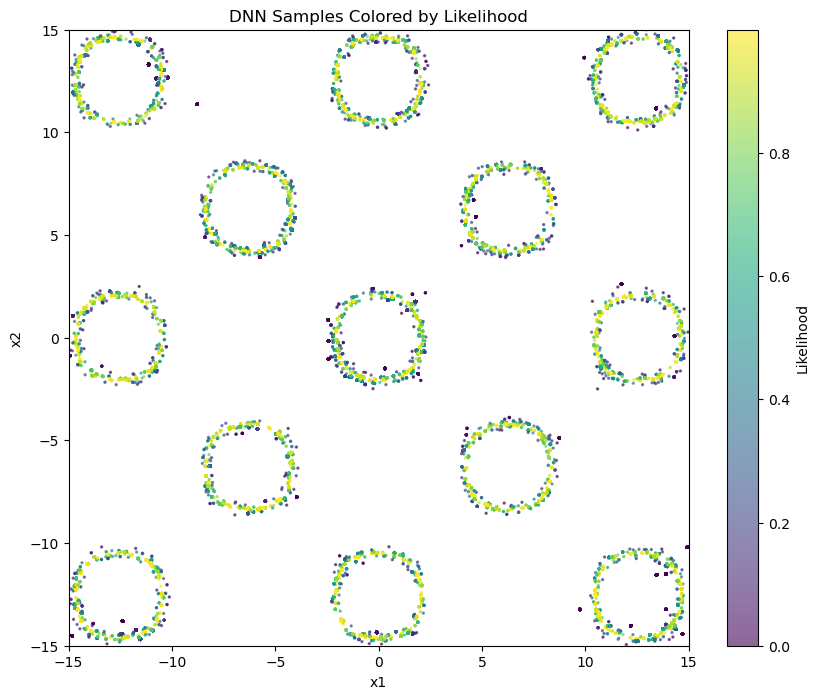

In [21]:
x1_range = (-15, 15)
x2_range = (-15, 15)
likelihood_values = np.array([likelihood(sample) for sample in sample_collect])
plot_heatmap(sample_collect, likelihood_values, x1_range, x2_range)